In [1]:
import numpy as np
import torch.utils.data
from sklearn.metrics import mean_squared_error
from data import MovieLens1MDataset, get_movielens_1m

import torch
import tqdm
from torch.utils.data import DataLoader


In [2]:
dataset = MovieLens1MDataset()

In [3]:
def train(model, optimizer, data_loader, criterion, device, log_interval=1000):
    model.train()
    total_loss = 0
    for i, (fields, target) in enumerate(tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0)):
        fields, target = fields.to(device), target.to(device)
        y = model(fields)
        loss = criterion(y, target.float())
        model.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        # if (i + 1) % log_interval == 0:
        #     print('    - loss:', total_loss / log_interval)
        #     total_loss = 0

        # wandb.log({"Total Loss": total_loss})


def test(model, data_loader, device):
    model.eval()
    targets, predicts = list(), list()
    with torch.no_grad():
        for fields, target in tqdm.tqdm(data_loader, smoothing=0, mininterval=1.0):
            fields, target = fields.to(device), target.to(device)
            y = model(fields)
            targets.extend(target.tolist())
            predicts.extend(y.tolist())

    return mean_squared_error(targets, predicts)

In [4]:
device = torch.device('cuda')
batch_size=512

In [5]:
train_len = int(len(dataset) * 0.8)
test_len = len(dataset) - train_len
train_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_len, test_len))

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=8)
test_data_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=8)


In [6]:
class FeaturesLinear(torch.nn.Module):
    def __init__(self, field_dims, output_dim=1):
        super().__init__()
        self.fc = torch.nn.Embedding(sum(field_dims), output_dim)
        self.bias = torch.nn.Parameter(torch.zeros((output_dim,)))
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return torch.sum(self.fc(x), dim=1) + self.bias


class FeaturesEmbedding(torch.nn.Module):
    def __init__(self, field_dims, embed_dim):
        super().__init__()
        self.embedding = torch.nn.Embedding(sum(field_dims), embed_dim)
        self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
        torch.nn.init.xavier_uniform_(self.embedding.weight.data)

    def forward(self, x):
        x = x + x.new_tensor(self.offsets).unsqueeze(0)
        return self.embedding(x)


class MultiLayerPerceptron(torch.nn.Module):
    def __init__(self, input_dim, embed_dims, dropout, output_layer=True):
        super().__init__()
        layers = list()
        for embed_dim in embed_dims:
            layers.append(torch.nn.Linear(input_dim, embed_dim))
            layers.append(torch.nn.BatchNorm1d(embed_dim))
            layers.append(torch.nn.ReLU())
            layers.append(torch.nn.Dropout(p=dropout))
            input_dim = embed_dim
        if output_layer:
            layers.append(torch.nn.Linear(input_dim, 1))
        self.mlp = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)


class FactorizationMachine(torch.nn.Module):
    def __init__(self, reduce_sum=True):
        super().__init__()
        self.reduce_sum = reduce_sum

    def forward(self, x):
        square_of_sum = torch.sum(x, dim=1) ** 2
        sum_of_square = torch.sum(x ** 2, dim=1)
        ix = square_of_sum - sum_of_square
        if self.reduce_sum:
            ix = torch.sum(ix, dim=1, keepdim=True)
        return 0.5 * ix

In [7]:
class DeepFactorizationMachineModel(torch.nn.Module):

    def __init__(self, field_dims, embed_dim, mlp_dims, dropout):
        super().__init__()
        self.linear = FeaturesLinear(field_dims)
        self.fm = FactorizationMachine(reduce_sum=True)
        self.embedding = FeaturesEmbedding(field_dims, embed_dim)
        self.embed_output_dim = len(field_dims) * embed_dim
        self.mlp = MultiLayerPerceptron(self.embed_output_dim, mlp_dims, dropout)

    def forward(self, x):
        embed_x = self.embedding(x)
        x = self.linear(x) + self.fm(embed_x) + self.mlp(embed_x.view(-1, self.embed_output_dim))

        return (torch.sigmoid(x.squeeze(1))*4) + 1


In [8]:
field_dims = dataset.dims

model = DeepFactorizationMachineModel(field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.5)
model = model.to(device)

<ipython-input-6-e500f599e687>:6: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
<ipython-input-6-e500f599e687>:17: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the

In [9]:
learning_rate = 0.001
weight_decay = 1e-6
epoch = 25

In [10]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [11]:
test_mse_list = []
for i in range(epoch):
    train(model, optimizer, train_data_loader, criterion, device, log_interval=100)
    test_f1 = test(model, test_data_loader, device)
    test_mse_list.append(test_f1)
    print('epoch:', i, 'test: f1-score:', test_f1)

test_f1 = test(model, test_data_loader, device)
test_mse_list.append(test_f1)
print('test f1-score:', test_f1)

torch.save(model.state_dict(), f'deepfm.pt')


 95%|█████████▌| 1487/1563 [00:58<00:02, 25.42it/s]


epoch: 0 test: f1-score: 0.9164186073897395


KeyboardInterrupt: 

In [11]:
model = DeepFactorizationMachineModel(field_dims, embed_dim=16, mlp_dims=(16, 16), dropout=0.5)
# model = model.to(device)
model.load_state_dict(torch.load(open('deepfm.pt', 'rb')))
model.eval()

<ipython-input-6-e500f599e687>:6: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the builtin `int` for which `np.compat.long` is itself an alias. Doing this will not modify any behaviour and is safe. When replacing `np.long`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  self.offsets = np.array((0, *np.cumsum(field_dims)[:-1]), dtype=np.long)
<ipython-input-6-e500f599e687>:17: DeprecationWarning: `np.long` is a deprecated alias for `np.compat.long`. To silence this warning, use `np.compat.long` by itself. In the likely event your code does not need to work on Python 2 you can use the

DeepFactorizationMachineModel(
  (linear): FeaturesLinear(
    (fc): Embedding(9992, 1)
  )
  (fm): FactorizationMachine()
  (embedding): FeaturesEmbedding(
    (embedding): Embedding(9992, 16)
  )
  (mlp): MultiLayerPerceptron(
    (mlp): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.5, inplace=False)
      (4): Linear(in_features=16, out_features=16, bias=True)
      (5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=16, out_features=1, bias=True)
    )
  )
)

In [12]:
import pandas as pd

In [ ]:
mse_df = pd.DataFrame(data={"MSE": test_mse_list[:-1], "epoch": range(1,epoch+1)})


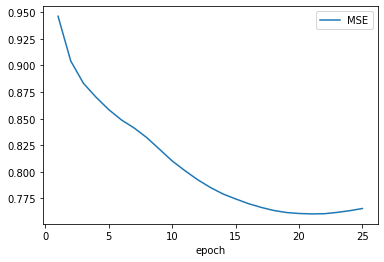

In [26]:
import matplotlib.pyplot as plt

mse_df.plot(kind='line', y='MSE', x='epoch')
plt.savefig("Line plot.png")



In [29]:
full_df = pd.merge(dataset.items, dataset.ratings,left_index=True, right_index=True)

In [30]:
rated_movies_for_user_2 = full_df[full_df['UserID'] == 1]

In [31]:
movies_df, users_df, ratings_df = get_movielens_1m()

In [32]:
rated_movies_for_user_2['UserID'] = rated_movies_for_user_2['UserID'] + 1
rated_movies_for_user_2['MovieID'] = rated_movies_for_user_2['MovieID'] + 1

<ipython-input-32-b9e82d673d16>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_movies_for_user_2['UserID'] = rated_movies_for_user_2['UserID'] + 1
<ipython-input-32-b9e82d673d16>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rated_movies_for_user_2['MovieID'] = rated_movies_for_user_2['MovieID'] + 1


In [33]:
full_df_with_movies = pd.merge(movies_df, rated_movies_for_user_2, how='left')

In [34]:
full_df_with_movies.drop('UserID', axis=1, inplace=True)

In [35]:
full_df_with_movies.head()

,MovieID,Title,Genres,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,NaN
1,2,Jumanji (1995),Adventure|Children's|Fantasy,NaN
2,3,Grumpier Old Men (1995),Comedy|Romance,NaN
3,4,Waiting to Exhale (1995),Comedy|Drama,NaN
4,5,Father of the Bride Part II (1995),Comedy,NaN


In [36]:
full_df_with_movies[~full_df_with_movies['Rating'].isnull()].head(30)

,MovieID,Title,Genres,Rating
20,21,Get Shorty (1995),Action|Comedy|Drama,1.0
93,95,Broken Arrow (1996),Action|Thriller,2.0
108,110,Braveheart (1995),Action|Drama|War,5.0
161,163,Desperado (1995),Action|Romance|Thriller,4.0
163,165,Die Hard: With a Vengeance (1995),Action|Thriller,3.0
232,235,Ed Wood (1994),Comedy|Drama,3.0
262,265,Like Water for Chocolate (Como agua para choco...,Drama|Romance,4.0
289,292,Outbreak (1995),Action|Drama|Thriller,3.0
315,318,"Shawshank Redemption, The (1994)",Drama,5.0
345,349,Clear and Present Danger (1994),Action|Adventure|Thriller,4.0


In [37]:
def update_rating(row):
    with torch.no_grad():
        if np.isnan(row['Rating']):
            return model(torch.Tensor([1,row['MovieID']-1]).type(torch.long)).item()
        else:
            return row['Rating']

In [38]:
full_df_with_movies['Rating'] = full_df_with_movies.apply(update_rating, axis=1)

In [40]:
full_df_with_movies.head(30)

,MovieID,Title,Genres,Rating
0,1,Toy Story (1995),Animation|Children's|Comedy,4.335940
1,2,Jumanji (1995),Adventure|Children's|Fantasy,3.129780
2,3,Grumpier Old Men (1995),Comedy|Romance,3.825294
3,4,Waiting to Exhale (1995),Comedy|Drama,3.272155
4,5,Father of the Bride Part II (1995),Comedy,3.502037
5,6,Heat (1995),Action|Crime|Thriller,3.681638
6,7,Sabrina (1995),Comedy|Romance,3.784366
7,8,Tom and Huck (1995),Adventure|Children's,2.784907
8,9,Sudden Death (1995),Action,2.954330
9,10,GoldenEye (1995),Action|Adventure|Thriller,3.453944
